<a href="https://colab.research.google.com/github/jdariasl/ML_2020/blob/master/Labs/lab5/lab5_parte2.ipynb">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Recuerda que una vez abierto, Da clic en "Copiar en Drive", de lo contrario no podras almacenar tu progreso**

Nota: no olvide ir ejecutando las celdas de código de arriba hacia abajo para que no tenga errores de importación de librerías o por falta de definición de variables.

# Laboratorio 5 - Parte 2 Máquinas de Vectores de Soporte

In [75]:
#configuración del laboratorio
# Ejecuta esta celda!
%load_ext autoreload
%autoreload 2
#for local 
#import sys ; sys.path.append('../commons/utils/')
!wget https://raw.githubusercontent.com/jdariasl/ML_2020/master/Labs/commons/utils/general.py -O general.py --no-cache
from general import configure_lab5_2
configure_lab5_2()
from lab5 import *
GRADER, dataset = part_2()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
--2020-11-24 23:52:47--  https://raw.githubusercontent.com/jdariasl/ML_2020/master/Labs/commons/utils/general.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14117 (14K) [text/plain]
Saving to: ‘general.py’

general.py          100%[===================>]  13.79K  --.-KB/s    in 0s      

2020-11-24 23:52:47 (82.9 MB/s) - ‘general.py’ saved [14117/14117]

lab configuration started
installing libraries
downloading files
lab configured
Dim de la base de datos original: (2000, 13)


## Ejercicio 1: Limipiar base de datos y completar código

En este ejercicio usaremos la regresión por vectores de soporte para resolver el problema de regresión de la base de datos AirQuality (https://archive.ics.uci.edu/ml/datasets/Air+Quality). Tener en cuenta que vamos a usar solo 2000 muestras.

Para esta base de datos vamos a realizar una limpieza de datos. Para ello vamos a completar la siguiente función para realizar:
1. **Remover** todos registros cuya variable objetivo es faltante (missing Value). Estos registros están marcados como -200, es decir, donde haya un valor -200 eliminaremos el registro.
2. **imputar los valores perdidos/faltantes** en cada una de las características, camos a usar el valor medio de la característica en especifico.
3. **Verificar** si quedaron valores faltantes
4. ** retornar** X (12 primeras columnas) y Y(la 13 columna).

In [77]:
# ejercicio de codigo
def clean_data(dataset):
    """funcion que limpia el dataset y obtiene X y Y"""
    
    database = dataset.copy()
    # identificar muetras cuya salida en un valor faltante
    idx_to_remove = []
    for i in range(np.size(dataset,0)):
        if dataset[i,12] == -200:
            idx_to_remove.append(i)
    
    #remover la muestras
    database = np.delete(database,idx_to_remove,0)

    print ("\nHay " + str(len(idx_to_remove)) + " valores perdidos en la variable de salida.")
    print ("\nDim de la base de datos sin las muestras con variable de salida perdido "+ str(np.shape(database)))

    ##Imputar
    print ("\nProcesando imputación de valores perdidos en las características . . .")
    for k in range(0,np.size(database,0)):
        for w in range(0,13):
            if database[k,w] ==-200 :
                all_feature = database[:,w]
                ## Se imputa con la media de toda la caracteristica
                # sin tener en cuenta las caractersiticas con valores faltantes               
                database[k,w] = np.mean(all_feature[all_feature!=-200])

    print ("Imputación finalizada.\n")


    ##Verificar
    missed_values = False
    for i in range(0,np.size(database,0)):
        if -200 in database[i,:]:
            missed_values = True
    if(missed_values):
        print ("Hay valores perdidos")
    else:
        print ("No hay valores perdidos en la base de datos. Ahora se puede procesar")
    X = database[:,0:11]
    Y = database[:,12]
    print(X.shape)
    print(Y.shape)
    return (X,Y)

In [78]:
# ignorar los prints
GRADER.run_test("ejercicio1", clean_data)


Hay 1 valores perdidos en la variable de salida.

Dim de la base de datos sin las muestras con variable de salida perdido (4, 13)

Procesando imputación de valores perdidos en las características . . .
Imputación finalizada.

No hay valores perdidos en la base de datos. Ahora se puede procesar
(4, 11)
(4,)
TEST EXITOSO!


Ahora usemos la función para tener nuestras variables X, Y

In [79]:
X,Y = clean_data(dataset)


Hay 41 valores perdidos en la variable de salida.

Dim de la base de datos sin las muestras con variable de salida perdido (1959, 13)

Procesando imputación de valores perdidos en las características . . .
Imputación finalizada.

No hay valores perdidos en la base de datos. Ahora se puede procesar
(1959, 11)
(1959,)


## Ejercicio 2: Experimentar SVM para regresión

Ahora vamos a crear la función para experimentar con la maquina de soporte vectorial. Para ellos vamos:
1. Usar la libreria de sklearn https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html. 
2. Vamos a variar tres parámetros del SVR: kernel,  gamma y el parametro de regularización.
3. Utilizar la metodología cross-validation con 5 folds.
4. Usar normalización de datos estandar implementada por sklearn
5. Extraer los vectores de soporte (observe los *atributos* del modelo SVR de sklearn). Recuerde que estos atributos son accesibles, una vez el modelo es entrenado
6. Utilizar el error cuadratico medio de sklearn.

**Notas**: 
- Deberiamos poder acceder a las funciones de la libreria de sklearn directamente por el nombre sin necesidad de importarlas. Las funciones que deberios utilizar ya están precargadas en la configuración del laboratorio.
- Llame todos los parametros de las funciones de sklearn de manera explicita. (i.e, si se quiere usar `max_iter` como parámetro para el SVR, debe crear el objeto: `SVR(max_iter = 100)`)

In [84]:
#ejercicio de código
def experiementarSVR(x, y, kernels, gammas,params_reg):
    """función que realizar experimentos sobre un SVM para regresión
    
    x: numpy.Array, con las caracteristicas del problema
    y: numpy.Array, con la variable objetivo
    kernels: List[str], lista con valores a pasar 
        a sklearn correspondiente al kernel de la SVM
    gammas: List[float], lista con los valores a pasar a
        sklean correspondiente el valor de los coeficientes para usar en el
        kernel
    params_reg: List[float], lista con los valores a a pasar a 
        sklearn para ser usados como parametro de regularización
    
    retorna: pd.Dataframe con las siguientes columnas:
        - 3 columnas con los tres parametros: kernel, gamma, param de regularizacion
        - error cuadratico medio en el cojunto test (promedio de los 5 folds)
        - intervalo de confianza del error cuadratico medio en el cojunto test 
            (desviacion estandar de los 5 folds)
        - % de Vectores de Soporte promedio para los 5 folds (0 a 100)
    """
    idx = 0
    kf = KFold(n_splits=5)
    # crear una lista con la combinaciones de los elementos de cada list
    kernels_gammas_regs = list(itertools.product(kernels, gammas, params_reg))
    resultados = pd.DataFrame()
    errores_test = []
    pct_support_vectors = []

    for params in kernels_gammas_regs:
        kernel, gamma, param_reg = params
        print("parametros usados", params) # puede usar para ver los params
                                                   #Works split(x,y[0:30,:]) (?)
        for train_index, test_index in kf.split(X=x,y=y,groups=None):
            
            X_train, X_test = x[train_index], x[test_index]
            y_train, y_test = y[train_index], y[test_index]  
            # normalizar los datos
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            svm = SVR( kernel= kernel , gamma= gamma , C= param_reg)
            # Entrenar el modelo
            svm.fit(X=X_train, y=y_train)
            # Validación del modelo
            ypred = svm.predict(X=X_test)
            
            # error y pct de vectores de soporte
            errores_test.append(mean_squared_error(y_true =y_test, y_pred = ypred))
            # contar muestras de entrenamiento
            n_train = X_train.shape[0]
            pct_vs = (svm.support_vectors_.shape[0]/ n_train) 
            pct_support_vectors.append(pct_vs)
        
        resultados.loc[idx,'kernel'] = kernel
        resultados.loc[idx,'gamma'] = gamma
        resultados.loc[idx,'param_reg'] = param_reg
        resultados.loc[idx,'error de prueba (promedio)'] = np.mean(errores_test)
        resultados.loc[idx,'error de prueba (intervalo de confianza)'] = np.std(errores_test)

        resultados.loc[idx,'% de vectores de soporte'] = np.mean(pct_support_vectors)*100
        idx+=1
        
    print(resultados)
    return (resultados)

In [82]:
GRADER.run_test("ejercicio2", experiementarSVR)

parametros usados ('linear', 1.0, 100)
parametros usados ('linear', 0.1, 100)
parametros usados ('rbf', 1.0, 100)
parametros usados ('rbf', 0.1, 100)
   kernel  ...  % de vectores de soporte
0  linear  ...                 96.666667
1  linear  ...                 96.666667
2     rbf  ...                 95.277778
3     rbf  ...                 94.791667

[4 rows x 6 columns]
TEST EXITOSO!


Para entrenar vamos a ignorar las dos primeras variables, estas corresponden a valores de fechas.

In [85]:
# vamos a realizar los experimentos
resultadosSVR = experiementarSVR(x =X[:,2:],y=Y,
                                 kernels=['linear', 'rbf'],
                                 gammas = [0.01,0.1],
                                 params_reg = [0.1, 1.0,10]
                                )

parametros usados ('linear', 0.01, 0.1)
parametros usados ('linear', 0.01, 1.0)
parametros usados ('linear', 0.01, 10)
parametros usados ('linear', 0.1, 0.1)
parametros usados ('linear', 0.1, 1.0)
parametros usados ('linear', 0.1, 10)
parametros usados ('rbf', 0.01, 0.1)
parametros usados ('rbf', 0.01, 1.0)
parametros usados ('rbf', 0.01, 10)
parametros usados ('rbf', 0.1, 0.1)
parametros usados ('rbf', 0.1, 1.0)
parametros usados ('rbf', 0.1, 10)
    kernel  ...  % de vectores de soporte
0   linear  ...                 16.386187
1   linear  ...                 16.201157
2   linear  ...                 16.152243
3   linear  ...                 16.210729
4   linear  ...                 16.171809
5   linear  ...                 16.152243
6      rbf  ...                 18.838228
7      rbf  ...                 18.485482
8      rbf  ...                 17.811268
9      rbf  ...                 17.934198
10     rbf  ...                 17.389732
11     rbf  ...                 16.863692

[

In [86]:
resultadosSVR.sort_values('error de prueba (promedio)')

,kernel,gamma,param_reg,error de prueba (promedio),error de prueba (intervalo de confianza),% de vectores de soporte
0,linear,0.01,0.1,0.012102,0.007237,16.386187
11,rbf,0.10,10.0,0.012227,0.007435,16.863692
1,linear,0.01,1.0,0.012456,0.007631,16.201157
3,linear,0.10,0.1,0.012478,0.007653,16.210729
4,linear,0.10,1.0,0.012545,0.007723,16.171809
10,rbf,0.10,1.0,0.012554,0.007516,17.389732
2,linear,0.01,10.0,0.012604,0.007783,16.152243
5,linear,0.10,10.0,0.012604,0.007783,16.152243
9,rbf,0.10,0.1,0.012909,0.007591,17.934198
8,rbf,0.01,10.0,0.013047,0.007872,17.811268


In [69]:
#@title Pregunta Abierta
#@markdown ¿Cuál es la finalidad de usar las funciones kernel en el modelo SVM?
respuesta_1 = "" #@param {type:"string"}

In [70]:
#@title Pregunta Abierta
#@markdown ¿el valor de gamma afecta el kernel lineal? justificar teniendo cuenta la teoria y la documentación de la libreria.
respuesta_2 = "" #@param {type:"string"}

Para analizar los resultados vamos a crear dos graficas para el mejor modelo encontrado:
1. vamos a graficar en el eje x el valor real, en el eje y el valor predicho. El modelo ideal deberia ser una recta que recuerda la identidad
2. en el eje x vamos a dejar un valor incremental y con colores vamos a diferenciar entre el valor real y el valor predicho



In [87]:
# dividir el conjunto
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

*** calculando predicciones ***


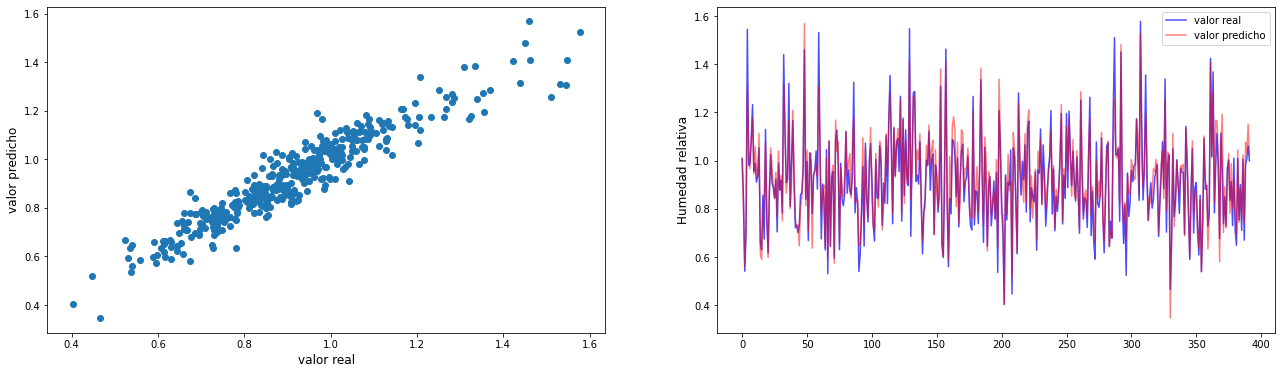

In [88]:
Ypred =  predict_svr(X_train,y_train,X_test,kernel = 'rbf' , gamma = 0.01, param_reg = 10)
f, ax = plt.subplots(ncols=2, sharex=False, sharey=False, figsize = (22,6))
ax[0].scatter(y_test, Ypred)
ax[0].set_xlabel('valor real', fontdict = {'fontsize': 12})
ax[0].set_ylabel('valor predicho', fontdict = {'fontsize': 12})
ax[1].plot(y_test, label = 'valor real', color = 'b', alpha = 0.7)
ax[1].plot(Ypred, label = 'valor predicho', color = 'r', alpha = 0.5)
ax[1].legend()
ax[1].set_ylabel('Humedad relativa', fontdict = {'fontsize': 12})
plt.show()

In [73]:
#@title Pregunta Abierta
#@markdown usando las anteriores graficas, ¿como calificaria el modelo de manera cualitativa?.
respuesta_3 = "" #@param {type:"string"}

## Ejercicio 3: Experimentar SVM para clasificación

En este ejercicio vamos a volver a resolver el problema de calsificacion de dígitos. Vamos usar solo 4 clases y realizaremos un pre-procesamiento mediante PCA (una tecnica proxima a practicar en el laboratorio)

In [89]:
Xcl, Ycl = load_digits(n_class=4,return_X_y=True)
#--------- preprocesamiento--------------------
pca = PCA(0.99, whiten=True)
Xcl = pca.fit_transform(Xcl)

Ahora vamos a crear la función para experimentar con la maquina de soporte vectorial. Para ellos vamos:

1. Usar la libreria de sklearn https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
2. Vamos a variar tres parámetros del SVC: kernel,  gamma y el parametro de regularización.
3. Utilizar la metodología cross-validation con 4 folds más adecuada para problemas de clasificación.
4. Usar normalización de datos estandar implementada por sklearn
5. Extraer los vectores de soporte (observe los *atributos* del modelo SVC de sklearn). Recuerde que estos atributos son accesibles una vez el modelo es entrenado
6. Utilizar como error el score de exactitud de la clasificación de sklearn.

**Notas**: 
- Deberiamos poder acceder a las funciones de la libreria de sklearn directamente por el nombre sin necesidad de importarlas. Las funciones que deberios utilizar ya están precargadas en la configuración del laboratorio.
- Llame todos los parametros de las funciones de sklearn de manera explicita. (i.e, si se quiere usar `max_iter` como parámetro para el SVC, debe crear el objeto: `SVC(max_iter = 100)`)

In [103]:
#ejercicio de código
def experiementarSVC(x, y, kernels, gammas,params_reg):
    """función que realizar experimentos sobre un SVM para clasificación
    
    x: numpy.Array, con las caracteristicas del problema
    y: numpy.Array, con la variable objetivo
    kernels: List[str], lista con valores a pasar 
        a sklearn correspondiente al kernel de la SVM
    gammas: List[float], lista con los valores a pasar a
        sklean correspondiente el valor de los coeficientes para usar en el
        kernel
    params_reg: List[float], lista con los valores a a pasar a 
        sklearn para ser usados como parametro de regularización
    
    retorna: pd.Dataframe con las siguientes columnas:
        - 3 columnas con los tres parametros: kernel, gamma, param de regularizacion
        - error cuadratico medio en el cojunto entrenamiento (promedio de los 4 folds)
        - error cuadratico medio en el cojunto test (promedio de los 4 folds)
        - % de Vectores de Soporte promedio para los 4 folds (0 a 100)
    """
    idx = 0
    kf = StratifiedKFold(n_splits=4)
    # crear una lista con la combinaciones de los elementos de cada list
    kernels_gammas_regs = list(itertools.product(kernels, gammas, params_reg))
    resultados = pd.DataFrame()
    
    for params in kernels_gammas_regs:
        kernel, gamma, param_reg = params
        print("parametros usados", params) # puede usar para ver los params
        errores_train = []
        errores_test = []
        pct_support_vectors = []
        for train_index, test_index in kf.split(x,y):
            
            X_train, X_test = x[train_index], x[test_index]
            y_train, y_test = y[train_index], y[test_index]  
            # normalizar los datos
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            svm = SVC( kernel= kernel , gamma= gamma , C= param_reg)
            # Entrenar el modelo
            svm.fit(X=X_train, y=y_train)
            # calculo de errores
            y_train_pred = svm.predict(X=X_train)
            y_test_pred = svm.predict(X=X_test)
            # error y pct de vectores de soporte
     
            errores_train.append(accuracy_score(y_true = y_train, y_pred = y_train_pred))
            errores_test.append(accuracy_score(y_true = y_test, y_pred = y_test_pred))
            # contar muestras de entrenamiento
            n_train = X_train.shape[0]
            pct_vs = (svm.support_vectors_.shape[0]/n_train)
            pct_support_vectors.append(pct_vs)
        
        resultados.loc[idx,'kernel'] = kernel
        resultados.loc[idx,'gamma'] = gamma
        resultados.loc[idx,'param_reg'] = param_reg
        resultados.loc[idx,'error de entrenamiento'] = np.mean(errores_train)
        resultados.loc[idx,'error de prueba'] = np.mean(errores_test)
        resultados.loc[idx,'% de vectores de soporte'] = np.mean(pct_support_vectors)*100
        idx+=1
    return (resultados)

In [104]:
GRADER.run_test("ejercicio3", experiementarSVC)

parametros usados ('linear', 1.0, 100)
parametros usados ('linear', 0.1, 100)
parametros usados ('rbf', 1.0, 100)
parametros usados ('rbf', 0.1, 100)
TEST EXITOSO!


In [ ]:
# vamos a realizar los experimentos
resultadosSVC = experiementarSVC(x = Xcl,y=Ycl,
                                 kernels=['linear', 'rbf'],
                                 gammas = [0.01,0.1],
                                 params_reg = [0.001, 0.01,0.1, 1.0,10]
                                )

resultadosSVC

In [ ]:
#@title Pregunta Abierta
#@markdown Explique en sus palabras ¿qué representan los vectores de soporte en un problema de clasificación? ¿Esa misma explicación se puede aplicar a un problema de regresión? justifique
respuesta_4 = "" #@param {type:"string"}

In [ ]:
#@title Pregunta Abierta
#@markdown Observando la documentación de SVC, sklearn usa estrategia one-vs-one. ¿Que diferencia existe al aplicar una estrategia  one-vs-rest?
respuesta_5 = "" #@param {type:"string"}

In [ ]:
# ver la relación de parametro de regularización y los vectores de soporte
import seaborn as sns
ax= sns.relplot(data = resultadosSVC, x = 'param_reg', y = '% de vectores de soporte', kind = 'line', hue ='kernel', aspect = 1.5)
ax.set(xscale="log")

In [ ]:
#@title Pregunta Abierta
#@markdown ¿qué relación observa entre el valor del parametro de regularización y los vectores de soporte? ¿como explica esta relación?
respuesta_6 = "" #@param {type:"string"}

**Para Tener en cuenta** 

sklearn tiene unos "wrappers", que implementan estrategias para la clasificación multiclase, uno  de estos wrappers, implementa la estrategia one-vs-rest: https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html.

Un wrapper, es un esquema de diseño común para "envolver" librerias/funciones con caracteristicas similares y poder modificar ciertos comportamientos. Vale la pena observar los ejemplos para saber como utilizar estas estrategias cuando sea necesario.

In [ ]:
GRADER.check_tests()

In [ ]:
#@title Integrantes
codigo_integrante_1 ='1017251689' #@param {type:"string"}
codigo_integrante_2 = ''  #@param {type:"string"}

----
esta linea de codigo va fallar, es de uso exclusivo de los profesores


In [ ]:
GRADER.grade()